/Users/nategruver/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_84216/1313326255.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


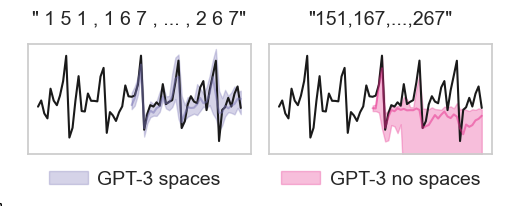

/var/folders/4z/0371zfqj5mx0rlct4r3qclfm0000gn/T/ipykernel_84216/1313326255.py:192: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


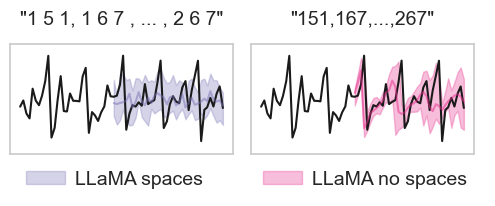

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import sys
sys.path.append("..")
from data.small_context import get_datasets
from data.metrics import calculate_crps

from matplotlib.patches import FancyBboxPatch

dsname = 'WineDataset'
train, test = get_datasets()[dsname]

pkl_fn = "../precomputed_outputs/tokenization/gpt.pkl"
with open(pkl_fn,'rb') as f:
    (df1,df2,data_list) = pickle.load(f)

sns.set(style='whitegrid', font_scale=1.)
# Define colors
color_base = sns.color_palette("Dark2")[2]
color_binary = sns.color_palette("Dark2")[0]
color_direct_encoding = sns.color_palette("Dark2")[3]

# Define data and labels

data_list = data_list[:1] + data_list[2:]

llama_fns = [
    "../precomputed_outputs/tokenization/llama_spaces.pkl",
    "../precomputed_outputs/tokenization/llama_no_spaces.pkl",
]
for fn in llama_fns:
    with open(fn,'rb') as f:
        results = pickle.load(f)
    data_list.append(results)

# 151, 167, 267
examples = [
    '" 1 5 1 , 1 6 7 , ... , 2 6 7"',#\n\n[" 1", " 5", " 1", " ,", ...]',
    '"151,167,...,267"'#\n\n["151", ",", "167", ... "267"]',
]
labels = ['GPT-3 spaces    ', 'GPT-3 no spaces  ',]
colors = [color_base, color_direct_encoding]

# Initialize a figure
fig, axs = plt.subplots(1, 2, figsize=(5, 1.8), sharex=True, sharey=True, constrained_layout = True)
axs = axs.flatten()

lines_labels = []
# Loop through data, labels, colors, and axes simultaneously
for dat, example, label, color, ax in zip(data_list[:2], examples, labels, colors, axs):
    combined = pd.concat([train, test]).iloc[110:]

    # Plot data
    l1, = ax.plot(combined, label='Ground Truth', color='k')
    
    if label == 'Base 10 & spaces':
        l2, = ax.plot(dat['median'], color=color)
    else:
        l2, = ax.plot(dat['median'], color=color, alpha=0.5)

    # Fill between
    lower = dat['samples'].quantile(0.1, axis=0)
    upper = dat['samples'].quantile(0.9, axis=0)
    if label == 'Base 10 & spaces':
        ax.fill_between(lower.index, lower, upper, alpha=0.5, color=color, label=label)
    elif label == 'Base 2 & spaces':
        ax.fill_between(lower.index, lower, upper, alpha=0.3, color=color, label=label)
    else:
        ax.fill_between(lower.index, lower, upper, alpha=0.3, color=color, label=label)

    lines_labels.extend([l1,l2])
    # remove y ticks
    ax.set_yticks([])
    ax.set_ylim([10000, 42000])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.set_title(example, fontsize=14, pad=15)

all_handles = []
all_labels = []
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    all_handles.append(handles[-1])
    all_labels.append(labels[-1])

lgd = fig.legend(
    all_handles, 
    all_labels, 
    loc="lower center", 
    bbox_to_anchor=(0.52,-0.19),
    ncol=4,
    fontsize=14,
    # columnspacing=0.0,
    handletextpad=0.5
    # frameon=True
)

# Calculate bounds to encompass both subplots
x0 = axs[0].get_position().x0
y0 = axs[1].get_position().y0
width = axs[0].get_position().width
height = (axs[0].get_position().y1 - axs[1].get_position().y0) + axs[1].get_position().height

# Create the FancyBboxPatch with rounded edges
fancy_box = FancyBboxPatch((x0, y0), width, height,
                           boxstyle="round,pad=0.02,rounding_size=0.15",
                           facecolor='none', edgecolor='black', lw=2)

# Add the box to the figure
fig.patches.append(fancy_box)


# plt.subplots_adjust(right=0.85)
# Improve layout
plt.tight_layout()

plt.savefig(f'outputs/encoding1.svg', bbox_inches='tight', dpi=300)
plt.show()

# 151, 167, 267
examples = [
    '"1 5 1, 1 6 7 , ... , 2 6 7"',#\n\n["1", " ", "5", " ", "1", ",", ...]',
    '"151,167,...,267"'#\n\n["1", "5", "1", ",", ...]',
]
labels = ['LLaMA spaces    ', 'LLaMA no spaces  ']
colors = [color_base, color_direct_encoding]

# Initialize a figure
fig, axs = plt.subplots(1, 2, figsize=(5, 1.8), sharex=True, sharey=True, constrained_layout = True)
axs = axs.flatten()

lines_labels = []
# Loop through data, labels, colors, and axes simultaneously
for dat, example, label, color, ax in zip(data_list[2:], examples, labels, colors, axs):
    combined = pd.concat([train, test]).iloc[110:]

    # Plot data
    l1, = ax.plot(combined, label='Ground Truth', color='k')
    # if not len(lines_labels):
    #     lines_labels.extend([l1])

    if label == 'Base 10 & spaces':
        l2, = ax.plot(dat['median'], color=color)
    else:
        # l2, = ax.plot(dat['median'], color='grey')
        l2, = ax.plot(dat['median'], color=color, alpha=0.5)
    # l2, = ax.plot(dat['median'], color=color)

    # Fill between
    lower = dat['samples'].quantile(0.1, axis=0)
    upper = dat['samples'].quantile(0.9, axis=0)
    if label == 'Base 10 & spaces':
        ax.fill_between(lower.index, lower, upper, alpha=0.5, color=color, label=label)
    elif label == 'Base 2 & spaces':
        ax.fill_between(lower.index, lower, upper, alpha=0.3, color=color, label=label)
    else:
        ax.fill_between(lower.index, lower, upper, alpha=0.3, color=color, label=label)

    lines_labels.extend([l1,l2])
    # remove y ticks
    ax.set_yticks([])
    ax.set_ylim([10000, 42000])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.set_title(example, fontsize=14, pad=15)

all_handles = []
all_labels = []
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    all_handles.append(handles[-1])
    all_labels.append(labels[-1])

lgd = fig.legend(
    all_handles, 
    all_labels, 
    loc="lower center", 
    bbox_to_anchor=(0.52,-0.19),
    ncol=4,
    fontsize=14,
    # columnspacing=0.0,
    handletextpad=0.5
    # frameon=True
)
# plt.subplots_adjust(right=0.85)
# Improve layout
plt.tight_layout()

plt.savefig(f'outputs/encoding2.svg', bbox_inches='tight', dpi=300)
plt.show()